In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.init as init
import time
import numpy as np
import torch.nn.functional as F
import os
from tqdm import tqdm
from ipywidgets import interactive, widgets

In [2]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

In [4]:
data = np.load("tiny_nerf_data.npz")

In [5]:
print(data.files)

['images', 'poses', 'focal']


In [6]:
images = data['images']
poses = data['poses']
focal = data['focal']

print("images shape", images.shape)
print("poses shape", poses.shape)
print("focal length", focal)

images shape (106, 100, 100, 3)
poses shape (106, 4, 4)
focal length 138.88887889922103


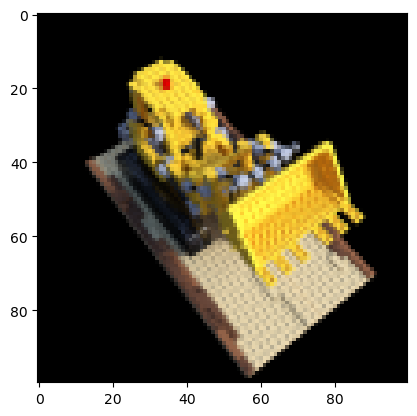

In [7]:
plt.imshow(images[3])

In [8]:
def encoding(x, L=10):
    res = [x]
    for i in range(L):
        for fn in [torch.sin, torch.cos]:
            # print("fn: ", fn)
            # print("input: ", (2**i) * torch.pi * x)
            # print("answer:", fn((2**i) * torch.pi * x))
            res.append(fn((2**i) * torch.pi * x))
    res = torch.cat(res, dim=-1)
    return res

In [9]:
x = torch.Tensor([1.0, 2.5, 9.4])
y = encoding(x, L=4)
y.shape
#  3 + 2 * 3 * L = 
# the 3 + because of the original xyz, and the 2 because sin + cos , 3 xyz

torch.Size([27])

In [10]:
print(y)

tensor([ 1.0000e+00,  2.5000e+00,  9.4000e+00, -8.7423e-08,  1.0000e+00,
        -9.5106e-01, -1.0000e+00, -3.3777e-07, -3.0902e-01,  1.7485e-07,
        -6.7553e-07,  5.8779e-01,  1.0000e+00, -1.0000e+00, -8.0902e-01,
         3.4969e-07,  1.3511e-06, -9.5106e-01,  1.0000e+00,  1.0000e+00,
         3.0901e-01,  6.9938e-07,  2.7021e-06, -5.8778e-01,  1.0000e+00,
         1.0000e+00, -8.0902e-01])


In [11]:

class NeRFOld(nn.Module):
    def __init__(self, num_fourier_features, layer_size, number_of_layers):
        super().__init__()
        self.num_fourier_features = num_fourier_features
        input_dim = 3 + 6*num_fourier_features
        self.linear1 = nn.Sequential(
            nn.Linear(input_dim, layer_size), 
            nn.ReLU()
        )

        layers = []
        for i in range(number_of_layers):
            layers.append(nn.Linear(layer_size, layer_size))
            layers.append(nn.ReLU())
        self.pre_skip_linear = nn.Sequential(*layers)

        self.linear_skip = nn.Sequential(nn.Linear(input_dim + layer_size, layer_size), nn.ReLU())

        layers = []
        for _ in range(2):
            layers.append(nn.Linear(layer_size, layer_size))
            layers.append(nn.ReLU())
        self.post_skip_linear = nn.Sequential(*layers)
        
        self.density_layer = nn.Sequential(nn.Linear(layer_size, 1), nn.ReLU())

        self.linear2 = nn.Linear(layer_size, layer_size)
        self.color_linear1 = nn.Sequential(nn.Linear(layer_size, layer_size // 2), nn.ReLU())
        self.color_linear2 = nn.Sequential(nn.Linear(layer_size // 2, 3), nn.Sigmoid())

        # self.layer1 = nn.Linear(3 + 6*num_fourier_features, layer_size)
        # nn.init.xavier_uniform_(self.layer1.weight)
        # nn.init.zeros_(self.layer1.bias)

        # self.pre_skip_linears = nn.ModuleList([nn.Linear(layer_size, layer_size) for _ in range(number_of_layers)])
        # for layer in self.layers:
        #     nn.init.xavier_uniform_(layer.weight)
        #     nn.init.zeros_(layer.bias)
            
        # self.rgb_layer = nn.Linear(layer_size, 3)
        # nn.init.xavier_uniform_(self.rgb_layer.weight)
        # nn.init.zeros_(self.rgb_layer.bias)

        # self.radiance_layer = nn.Linear(layer_size, 1)
        # nn.init.xavier_uniform_(self.radiance_layer.weight)
        # nn.init.zeros_(self.radiance_layer.bias)

    def forward(self, input):
        positions = input[..., :3]
        # view_dirs = input[..., 3:]

        pos_encoding = encoding(positions, L=self.num_fourier_features)
        # view_encoding = encoding(view_dirs, L=4)

        # print(pos_encoding.shape)
        x = self.linear1(pos_encoding)
        x = self.pre_skip_linear(x)

        #  skip connection
        x = torch.cat([x, pos_encoding], dim=-1)
        x = self.linear_skip(x)

        x = self.post_skip_linear(x)

        sigma = self.density_layer(x)
  
        x = self.linear2(x)
        x = self.color_linear1(x)
        rgb = self.color_linear2(x)
        return torch.cat([sigma, rgb], dim=-1)
    
        # x = nn.functional.relu(self.layer1(x))
        # for layer in self.layers:
        #   x = nn.functional.relu(layer(x))
        # rgb = torch.sigmoid(self.rgb_layer(x))
        # radiance = torch.relu(self.radiance_layer(x))
        # return torch.cat([rgb, radiance], dim=-1)

class NeRF(nn.Module):
    def __init__(self, num_fourier_features=10, layer_size=256, number_of_layers=4) -> None:
    # def __init__(self, num_fourier_features=63, view_enc_dim=27, hidden=256) -> None:
        # num_fourier_features=10,layer_size=256, number_of_layers=4
        super().__init__()
        self.num_fourier_features = num_fourier_features
        pos_enc_dim = 3 + 6*num_fourier_features
        # view_enc_dim = 
        self.linear1 = nn.Sequential(nn.Linear(pos_enc_dim, layer_size), nn.ReLU())

        # layers = []
        # for i in range(number_of_layers):
        #     layers.append(nn.Linear(layer_size, layer_size))
        #     layers.append(nn.LayerNorm(layer_size))
        #     layers.append(nn.ReLU())
        # self.linear2 = nn.Sequential(*layers)
            
        self.density_layer = nn.Sequential(nn.Linear(layer_size,1),nn.ReLU())


        self.color_linear1 = nn.Sequential(nn.Linear(layer_size,layer_size//2),nn.ReLU())
        self.color_linear2 = nn.Sequential(nn.Linear(layer_size//2,3),nn.Sigmoid())

    def forward(self, input):
        # input = (?, ?, 5)
        # input[-1][0:3] = xyz
        # input[-1][3:5] is the view direction
        positions = input[..., :3]
        # view_dirs = input[..., 3:]

        pos_enc = encoding(positions, L=self.num_fourier_features)
        # view_enc = encoding(view_dirs, L=4)
        
        x = self.linear1(pos_enc)
        # x = self.linear2(x)

        
        density = self.density_layer(x)

        # print(x.shape)
        # print(view_enc.shape)
        # x = torch.concat([x, view_enc])
        x = self.color_linear1(x)
        rgb = self.color_linear2(x)

        # x = torch.cat([x, ])
        # rgb = self.color_linear1()
        return torch.cat([density,rgb], dim=-1)
        # return rgb, density

In [12]:
xyz = torch.tensor(
    [
    [0, 0, 0],
    [1, 2, 3],
    [-1, -2, -3]
    ])

In [13]:
sample_model = NeRF(num_fourier_features=10, layer_size=256, number_of_layers=4).to(device)

In [14]:
out = sample_model(xyz.to(device))

In [15]:
out

tensor([[0.0000, 0.4875, 0.4578, 0.5209],
        [0.0000, 0.4864, 0.4619, 0.5227],
        [0.0000, 0.4674, 0.4451, 0.4980]], device='cuda:0',
       grad_fn=<CatBackward0>)

In [16]:
rgb = out[:, 1:]
density = out[:, 0]

In [17]:
print(rgb)
print(density)
print(density.shape)
print(rgb.shape)

tensor([[0.4875, 0.4578, 0.5209],
        [0.4864, 0.4619, 0.5227],
        [0.4674, 0.4451, 0.4980]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([0., 0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
torch.Size([3])
torch.Size([3, 3])


In [18]:
focal

array(138.8888789)

In [19]:
def generate_rays(W, H, focal, camera_to_world):
    device = camera_to_world.device
    focal = torch.from_numpy(focal).float().to(device)

    x, y = torch.meshgrid(
      torch.arange(W, dtype=torch.float32, device=device),
      torch.arange(H, dtype=torch.float32, device=device),
      indexing='xy'
    )


    # // Indexing is (x, y, z)
    # row, clumn of image


    dirs = torch.stack([(x - W *.5) / focal, -(y- H*.5)/focal, -torch.ones_like(x, device=device)], -1)
    # print(dirs[500][500])
    ray_dirs = dirs.unsqueeze(dim=2) * camera_to_world[:3, :3]
    ray_dirs = torch.sum(ray_dirs, -1)
    ray_dirs = ray_dirs.view(-1, 3)
    ray_o = camera_to_world[:3, -1].expand(ray_dirs.shape)
    # print(ray_dirs.shape)
    # print(ray_o.shape)
    # print(ray_dirs.sum(-1).shape)
    # print(dirs.unsqueeze(dim=2).shape)
    # print(dirs[..., None, :].shape)
    # rays_d = torch.sum(dirs[..., None, :] * c2w[:3, :3], -1)

    # print(dirs[0][500])
    return ray_o, ray_dirs

    dirs = torch.stack

    # i has values of the rows
    # j has values of the column
    # print(x[500][400], y[500][400]) # 400, 500
    # return dirs
    # print(i.shape)
    # print(j.shape)
    
generate_rays(1000, 1000, np.array(1), torch.eye(4))

(tensor([[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]),
 tensor([[-500.,  500.,   -1.],
         [-499.,  500.,   -1.],
         [-498.,  500.,   -1.],
         ...,
         [ 497., -499.,   -1.],
         [ 498., -499.,   -1.],
         [ 499., -499.,   -1.]]))

In [20]:
print(generate_rays(1000, 1000, np.array(1), torch.eye(4)))
# print(generate_rays(1000, 1000, np.array(1), torch.eye(4))[0].shape)
# print(get_rays(1000, 1000, np.array(1), torch.eye(4))[1].shape)

(tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]), tensor([[-500.,  500.,   -1.],
        [-499.,  500.,   -1.],
        [-498.,  500.,   -1.],
        ...,
        [ 497., -499.,   -1.],
        [ 498., -499.,   -1.],
        [ 499., -499.,   -1.]]))


In [21]:
def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, device, rand=False, embed_fn=None, chunk=1024*4):
    def batchify(fn, chunk):
        return lambda inputs: torch.cat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)

    # Sampling
    z_vals = torch.linspace(near, far, steps=N_samples, device=device)

    if rand:
        z_vals += torch.rand(*z_vals.shape[:-1], N_samples, device=rays_o.device) * (far - near) / N_samples

    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]

    # Normalize view directions
    view_dirs = rays_d / torch.norm(rays_d, dim=-1, keepdim=True)
    view_dirs = view_dirs[..., None, :].expand(pts.shape)

    input_pts = torch.cat((pts, view_dirs), dim=-1)
    raw = batchify(network_fn, chunk)(input_pts)

    # Apply activations here instead of in network
    sigma_a = raw[...,0]  # Shape: [batch, N_samples]
    rgb = raw[...,1:]    # Shape: [batch, N_samples, 3]

    # Improved volume rendering
    dists = z_vals[..., 1:] - z_vals[..., :-1]  # Shape: [batch, N_samples-1]
    dists = torch.cat([dists, torch.tensor([1e10], device=device)], -1)

    # No need to manually expand dists as broadcasting will handle it
    alpha = 1. - torch.exp(-sigma_a * dists)  # Shape: [batch, N_samples]
    alpha = alpha.unsqueeze(-1)  # Shape: [batch, N_samples, 1]

    # Computing transmittance
    ones_shape = (alpha.shape[0], 1, 1)
    T = torch.cumprod(
        torch.cat([
            torch.ones(ones_shape, device=device),
            1. - alpha + 1e-10
        ], dim=1),
        dim=1
    )[:, :-1]  # Shape: [batch, N_samples, 1]

    weights = alpha * T  # Shape: [batch, N_samples, 1]

    # Compute final colors and depths
    rgb_map = torch.sum(weights * rgb, dim=1)  # Sum along sample dimension
    depth_map = torch.sum(weights.squeeze(-1) * z_vals, dim=-1)  # Shape: [batch]
    acc_map = torch.sum(weights.squeeze(-1), dim=-1)  # Shape: [batch]

    return rgb_map, depth_map, acc_map

In [22]:
model = NeRF(num_fourier_features=10, layer_size=512, number_of_layers=4).to(device)


iteration 0, loss is: 0.16964568197727203


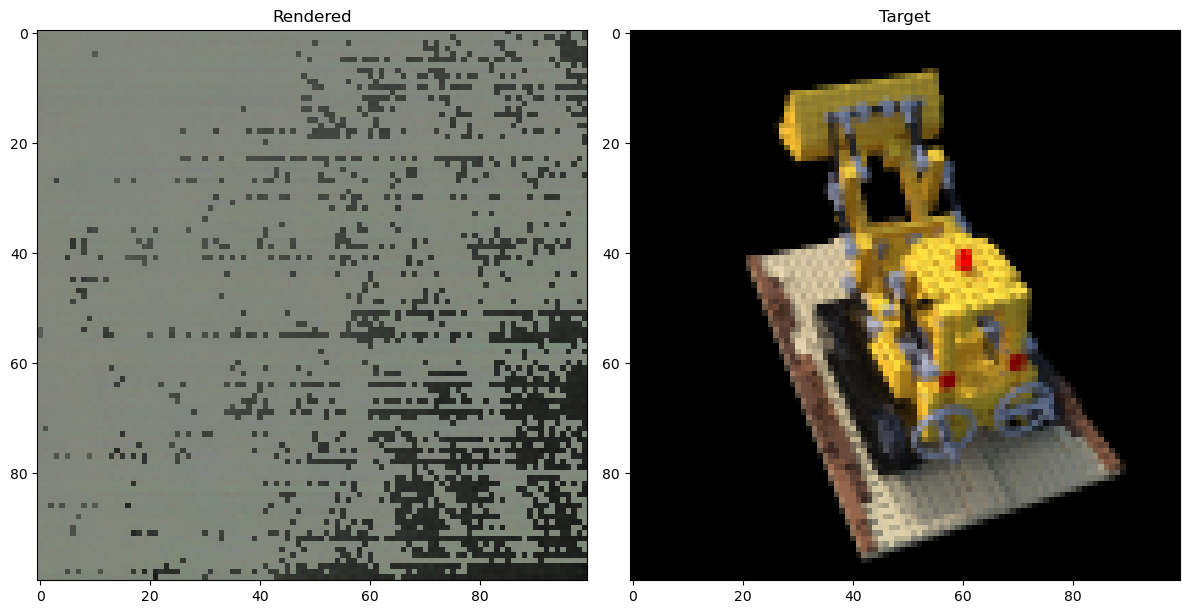

iteration 1000, loss is: 0.01035512238740921


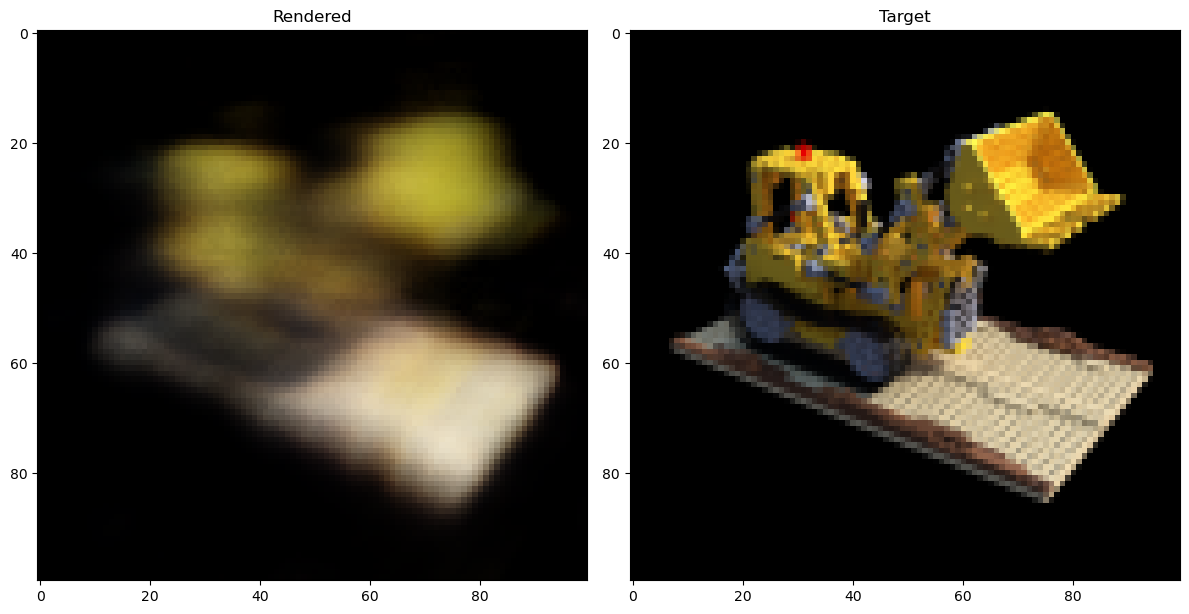

iteration 2000, loss is: 0.008184915408492088


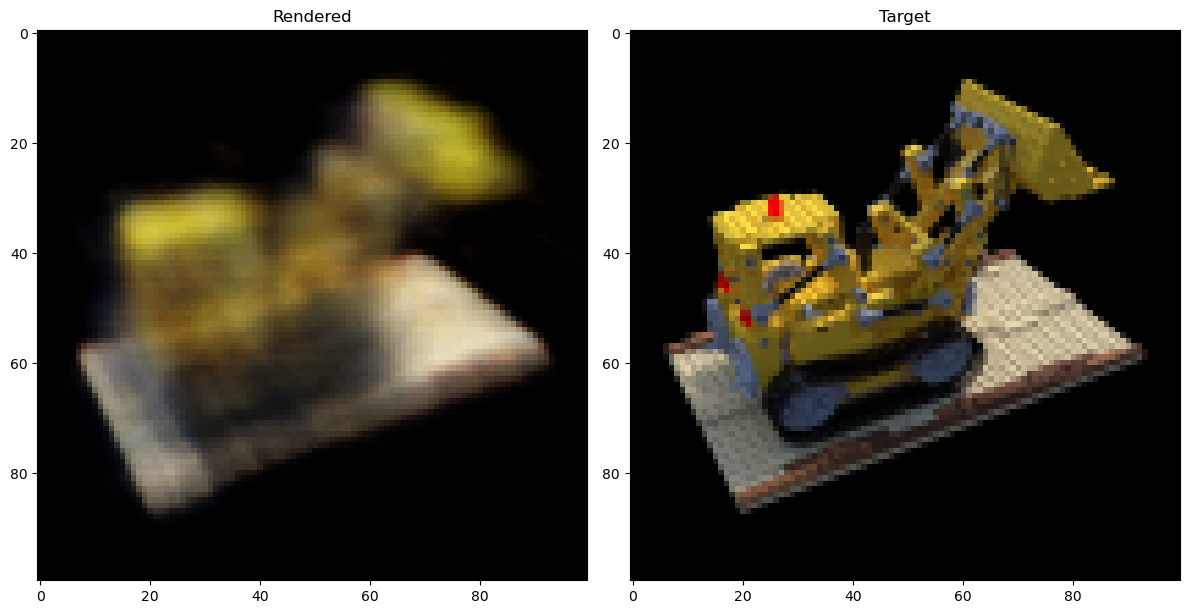

iteration 3000, loss is: 0.009558442048728466


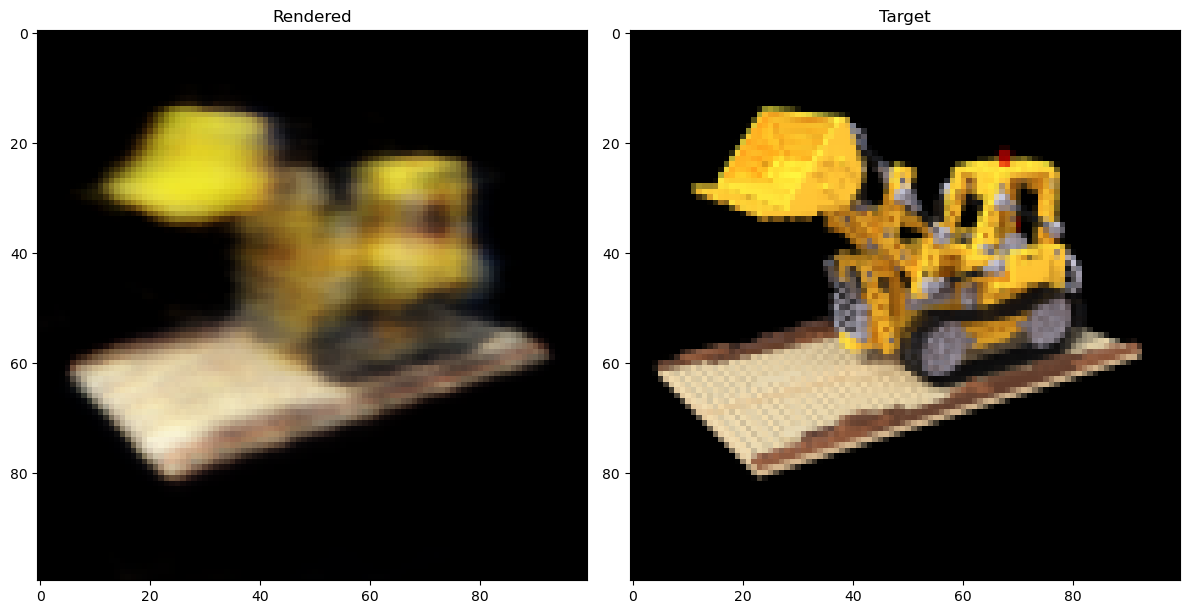

iteration 4000, loss is: 0.009002956561744213


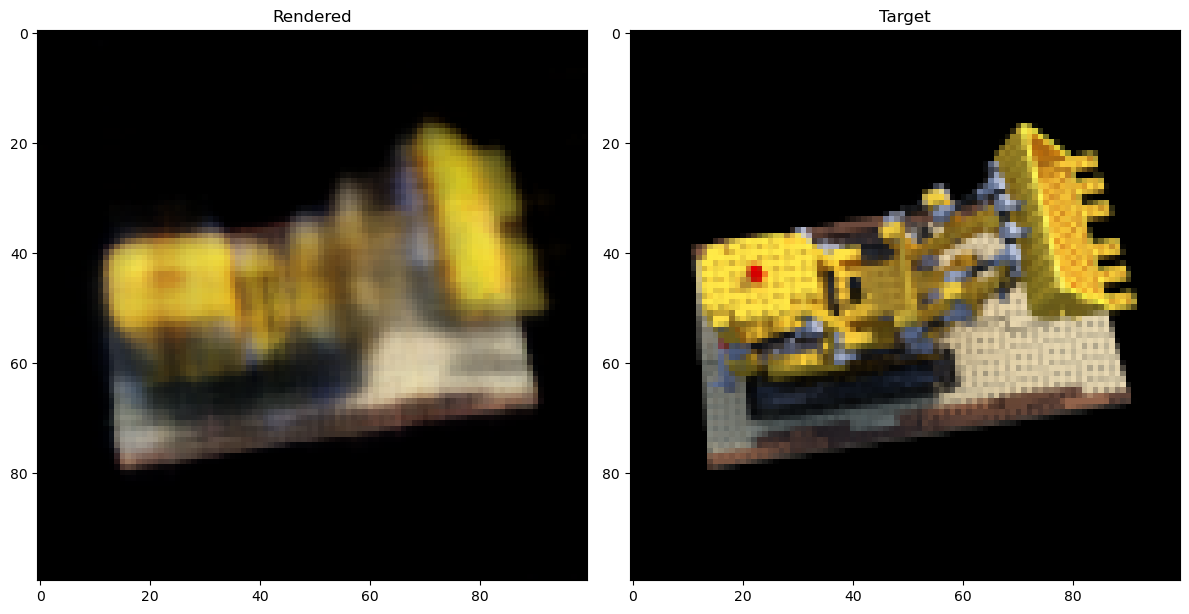

iteration 5000, loss is: 0.00813999678939581


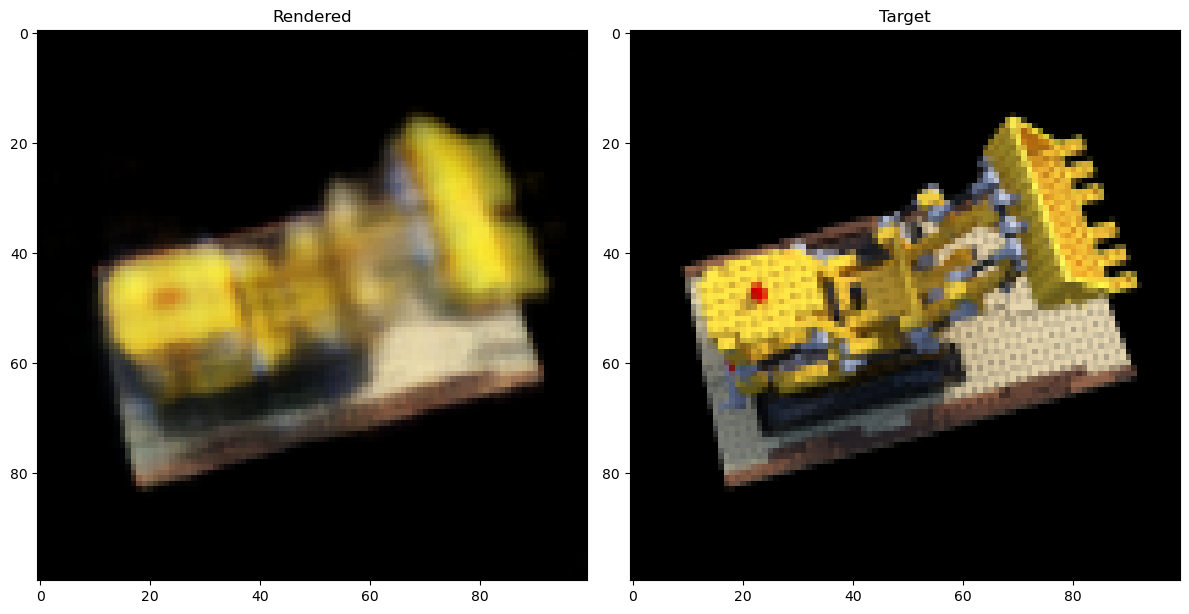

iteration 6000, loss is: 0.005507807247340679


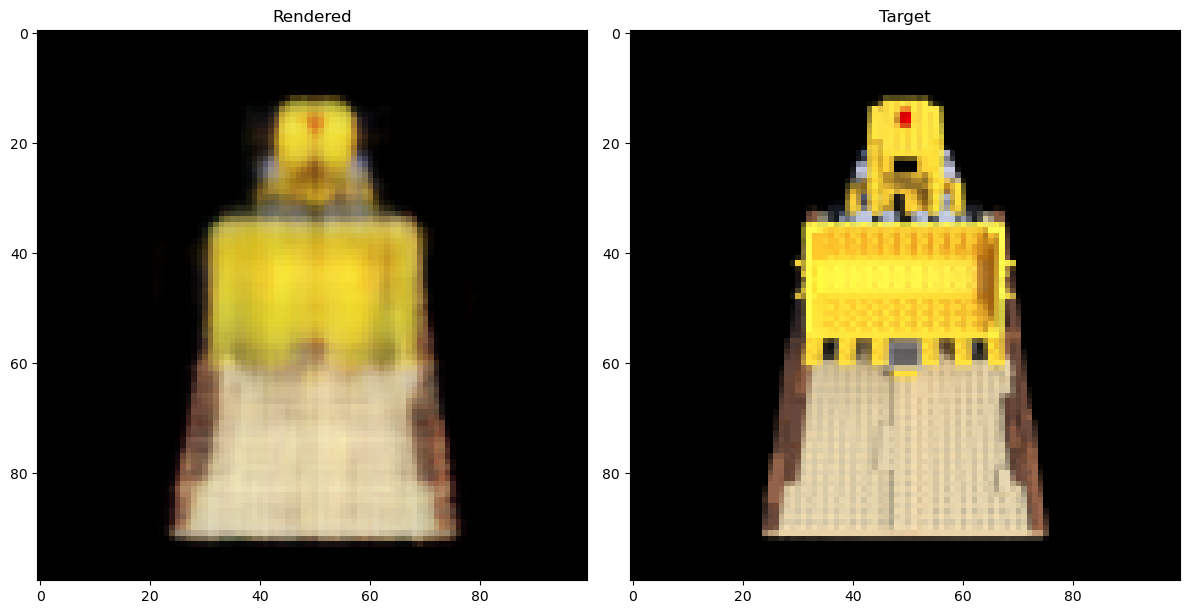

iteration 7000, loss is: 0.007029188796877861


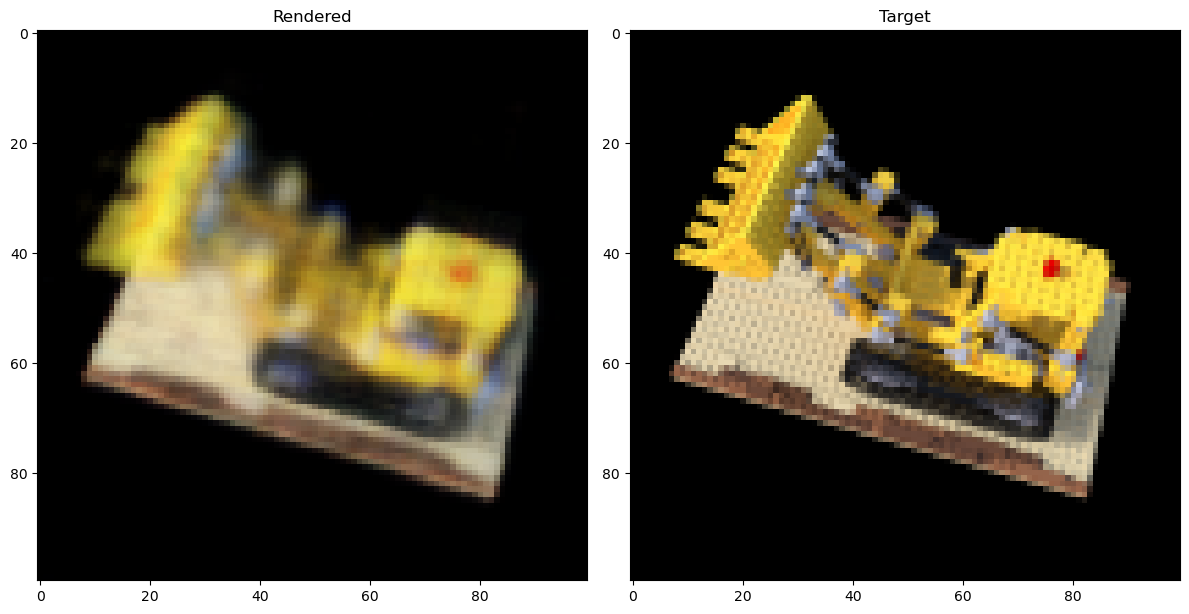

iteration 8000, loss is: 0.005460652522742748


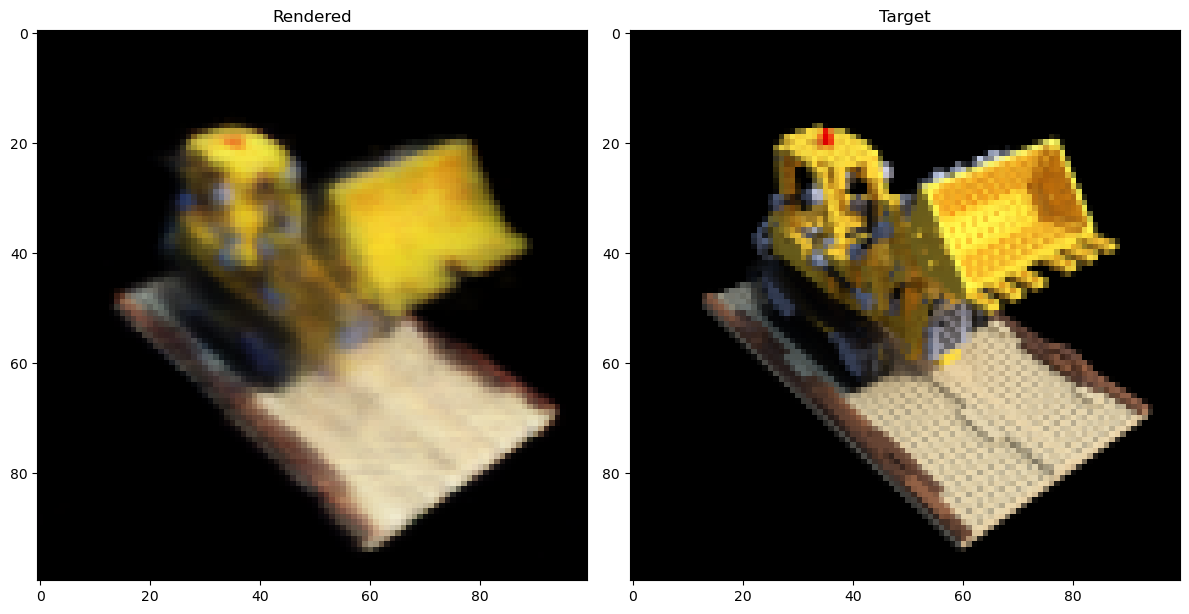

iteration 9000, loss is: 0.004645786248147488


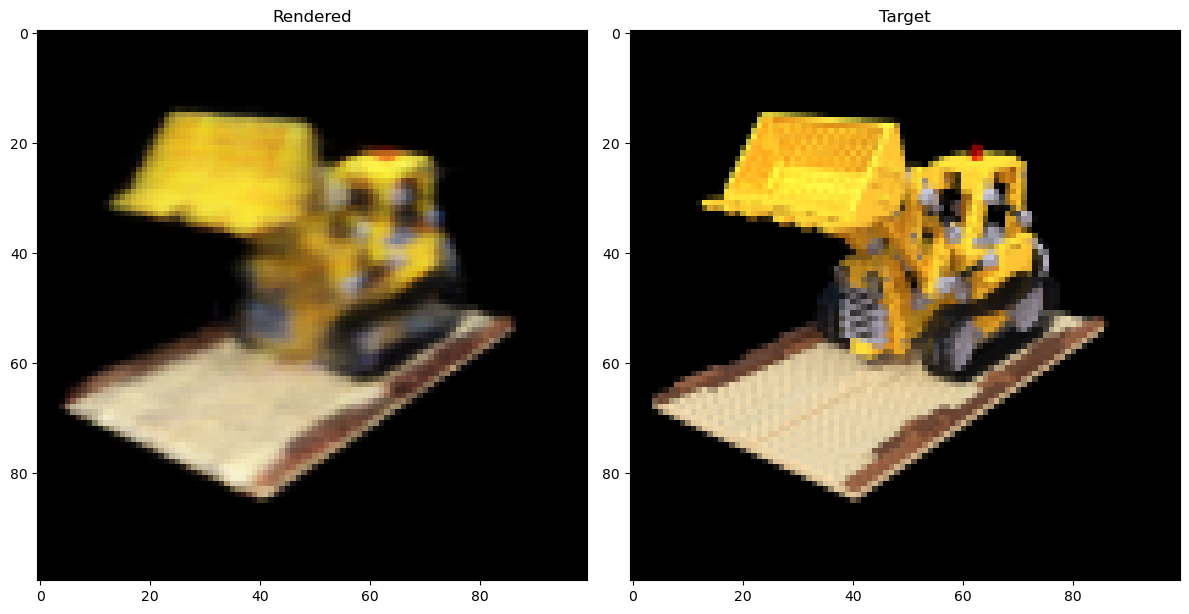

iteration 10000, loss is: 0.004437231458723545


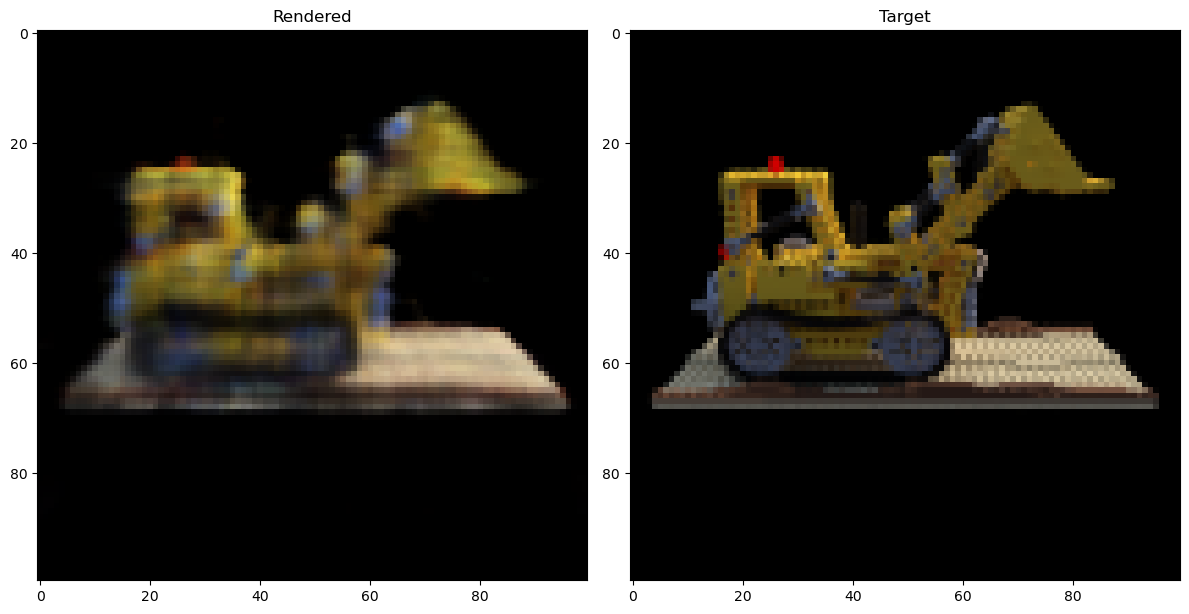

iteration 11000, loss is: 0.005385286640375853


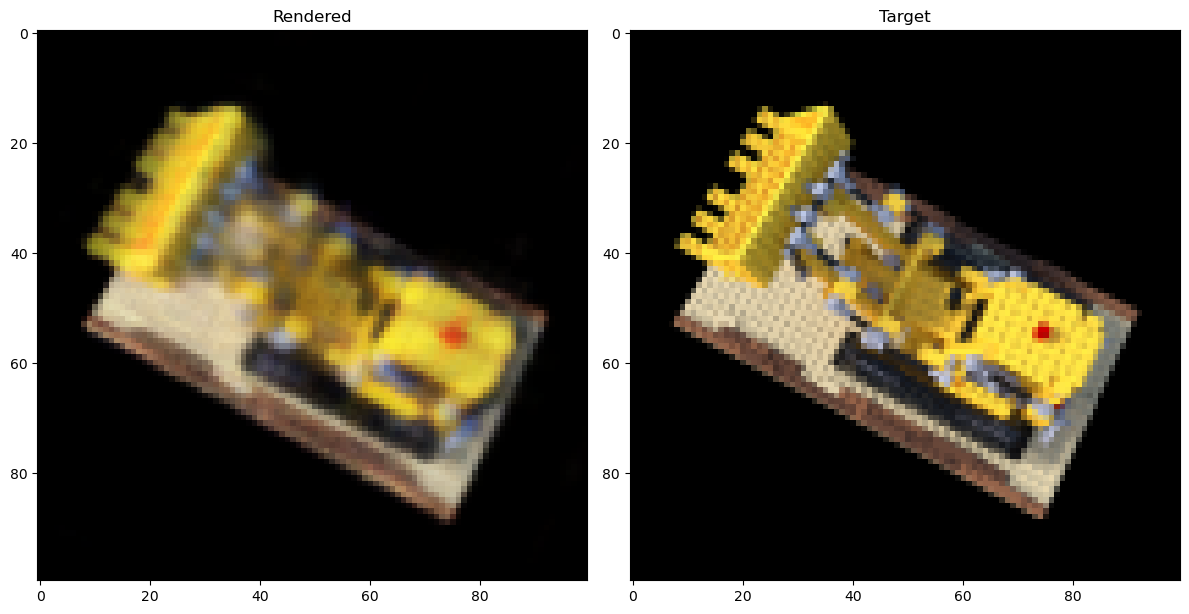

iteration 12000, loss is: 0.004290024749934673


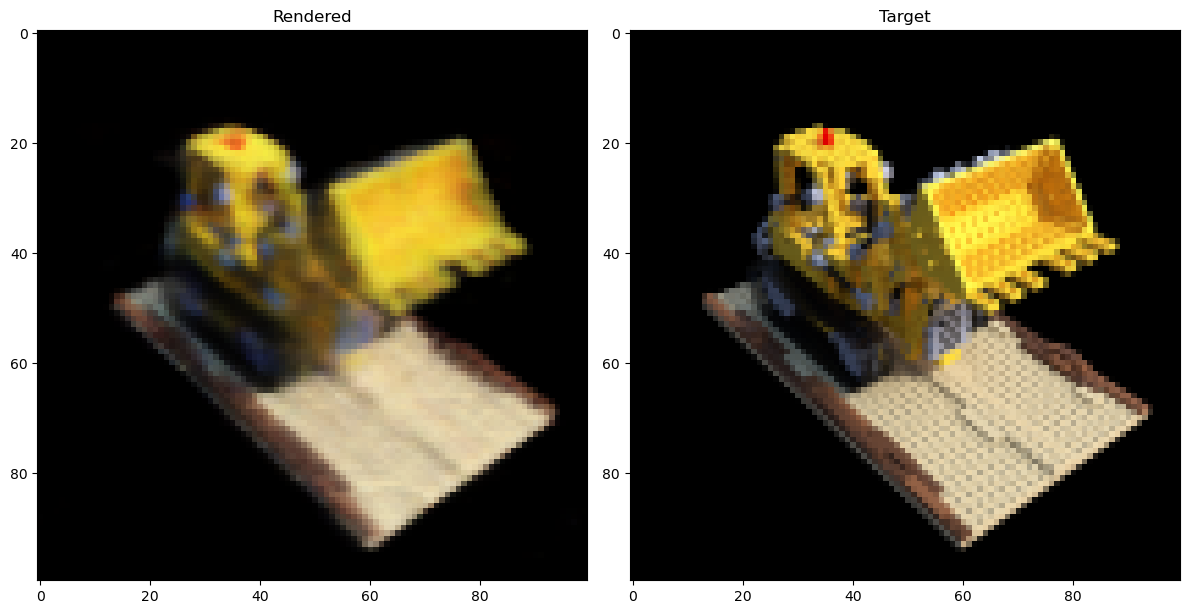

iteration 13000, loss is: 0.005503471475094557


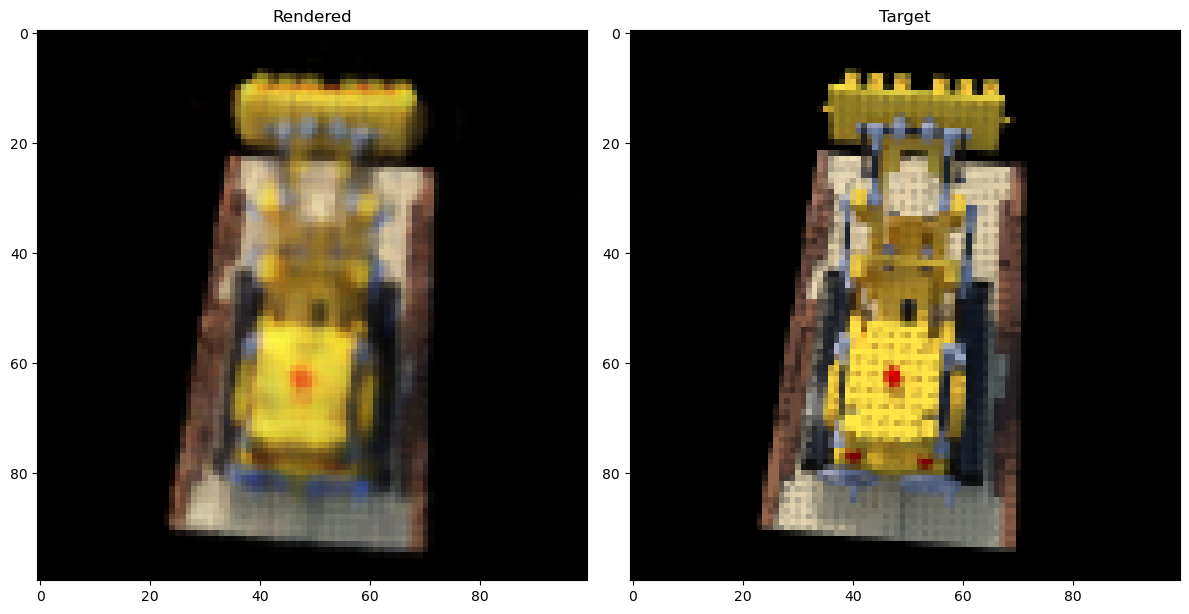

iteration 14000, loss is: 0.0035603416617959738


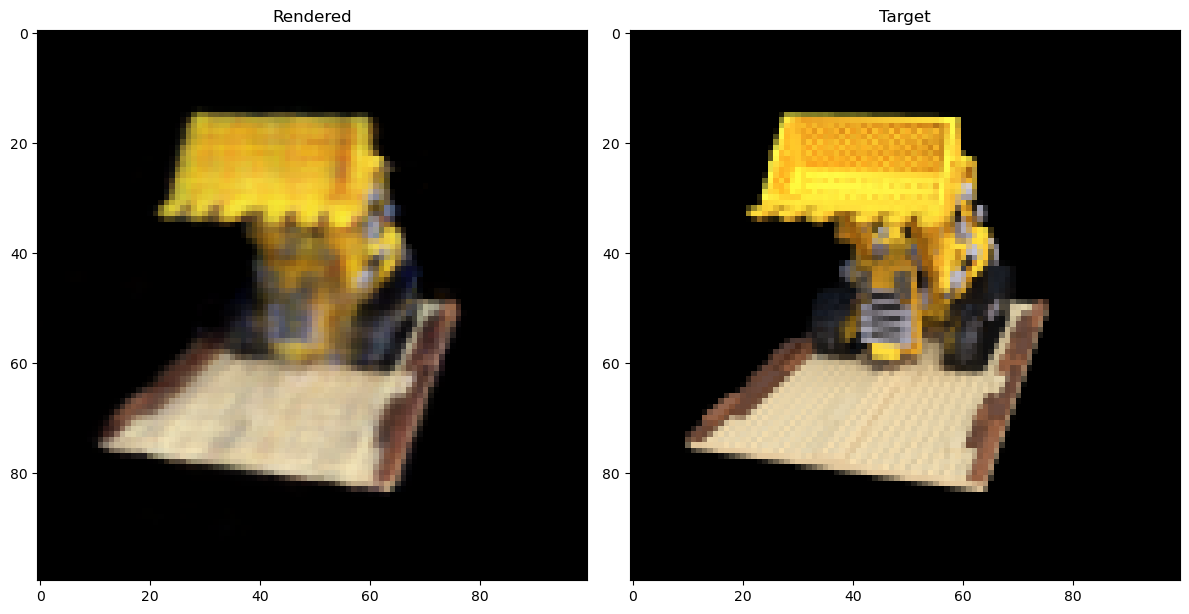

iteration 15000, loss is: 0.004309352487325668


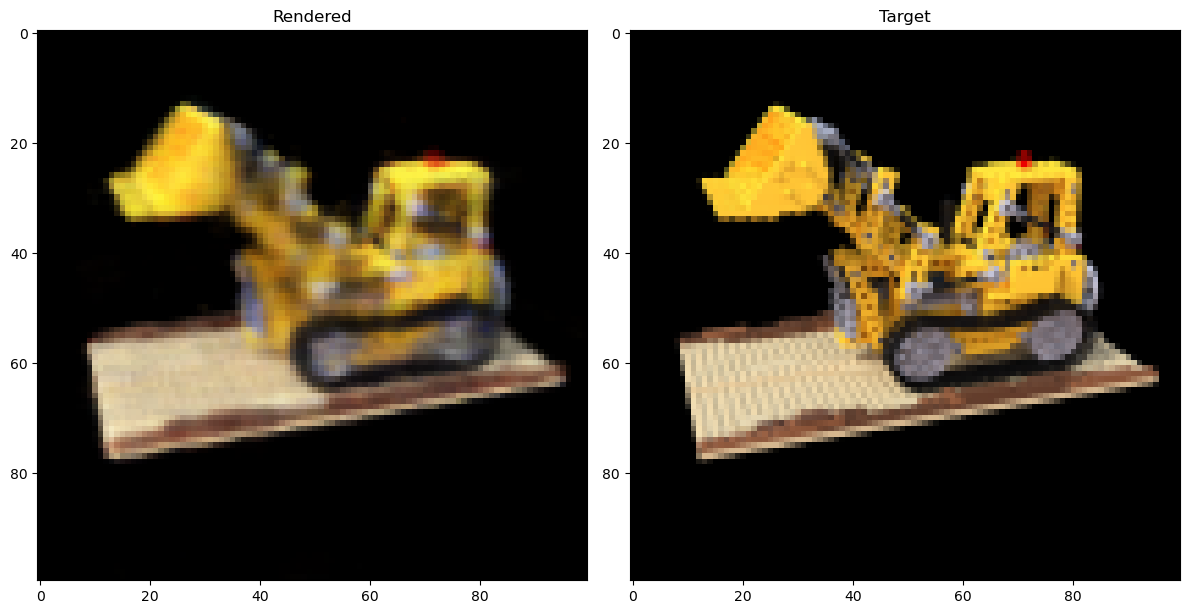

iteration 16000, loss is: 0.0038366797380149364


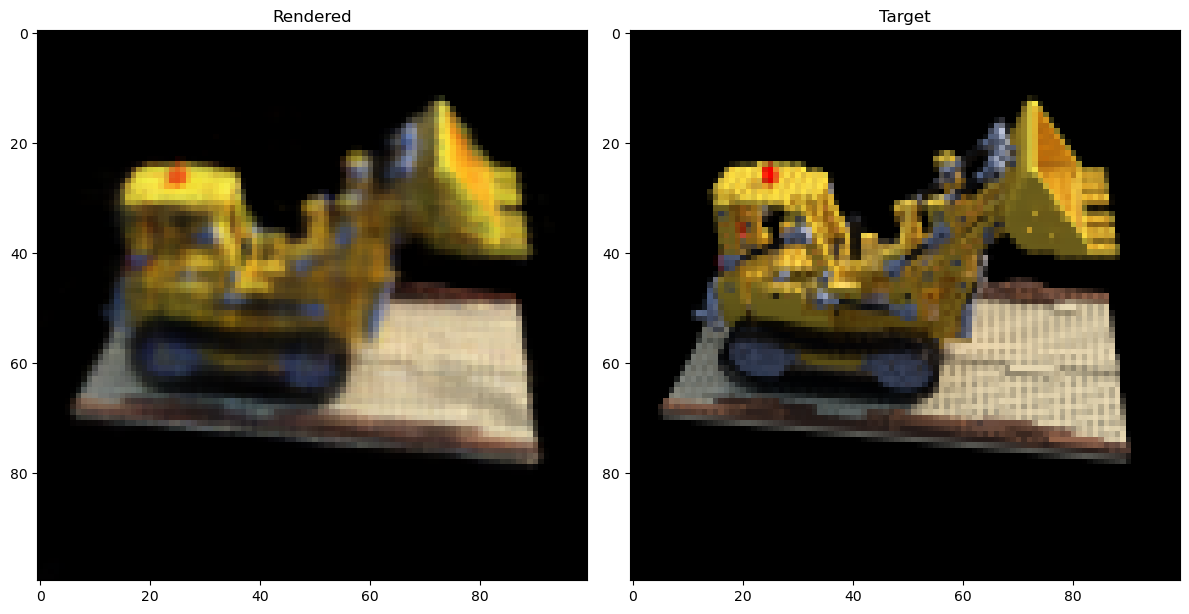

iteration 17000, loss is: 0.0031384010799229145


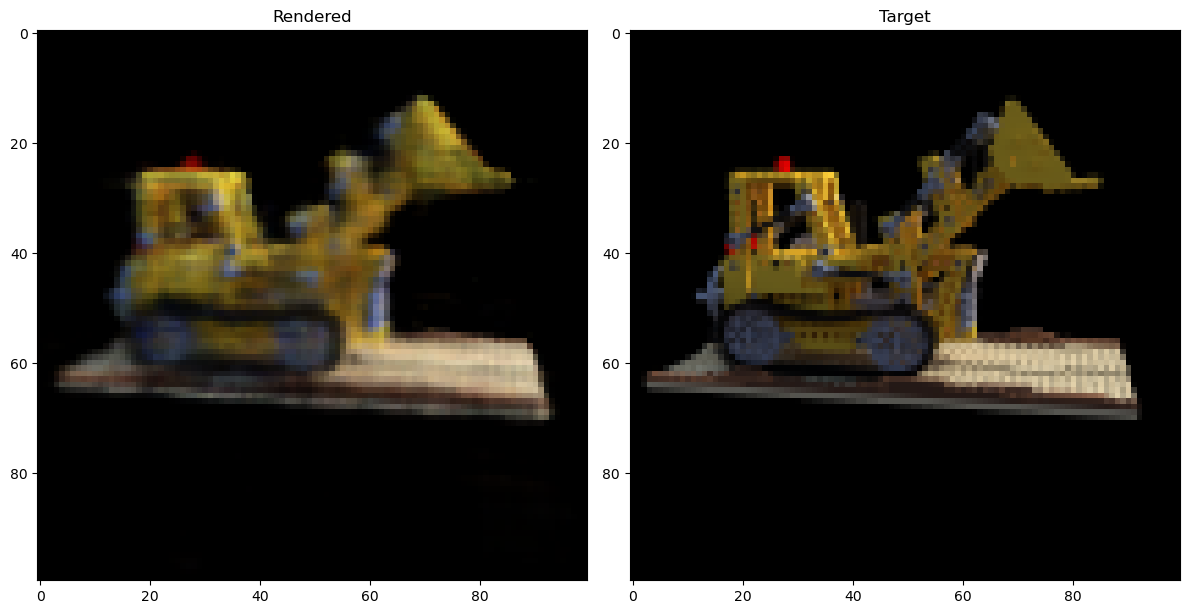

iteration 18000, loss is: 0.0026680922601372004


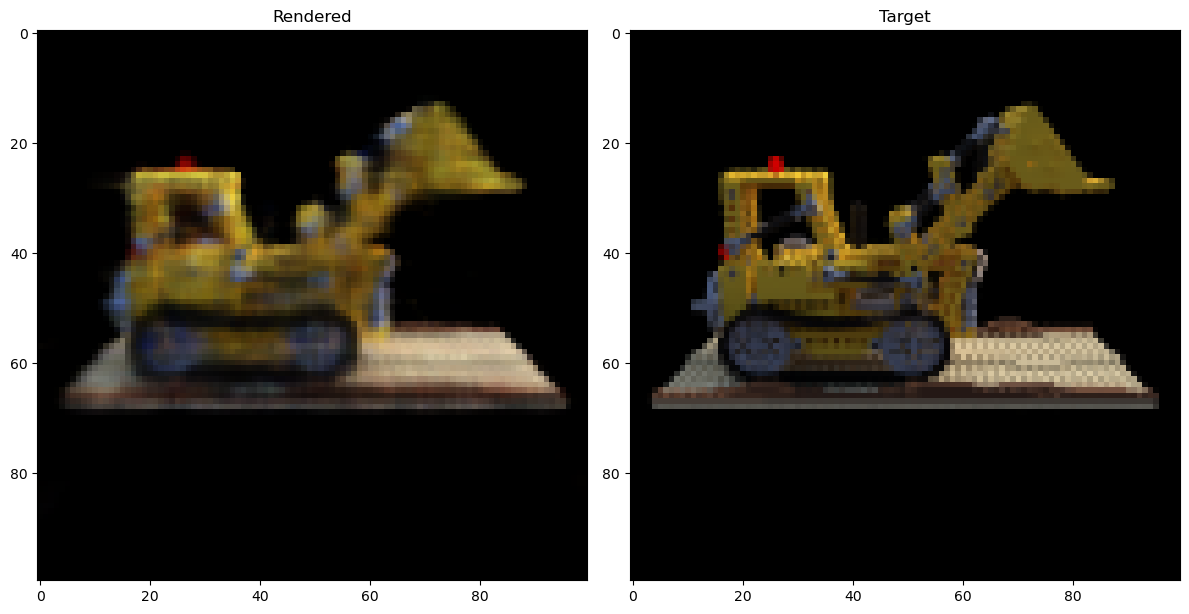

iteration 19000, loss is: 0.0044510141015052795


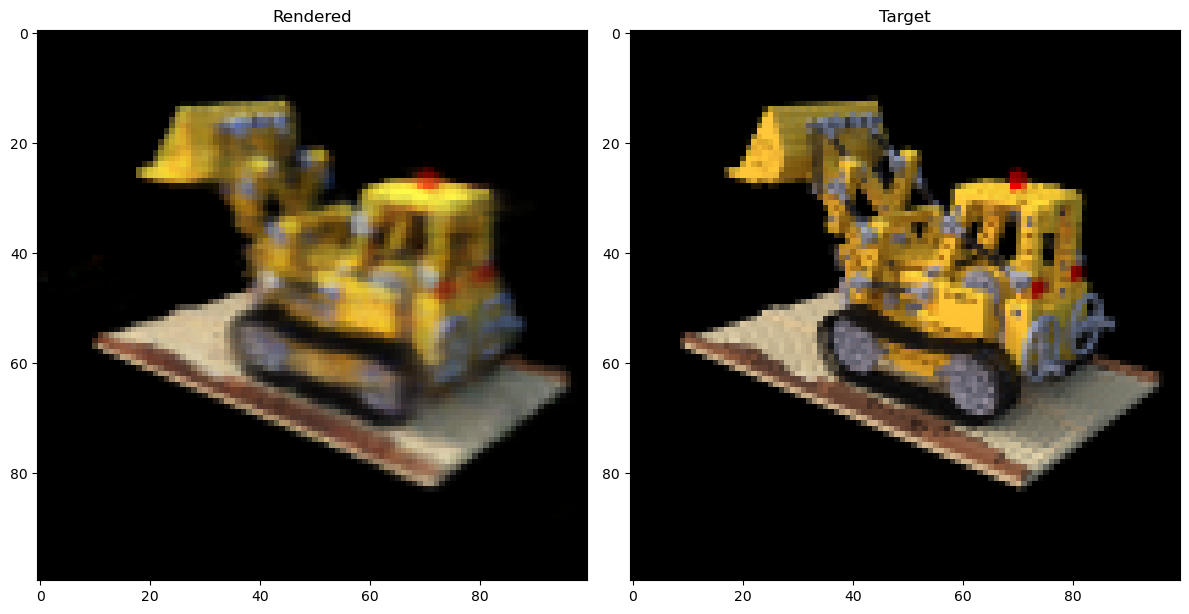

iteration 20000, loss is: 0.00517996633425355


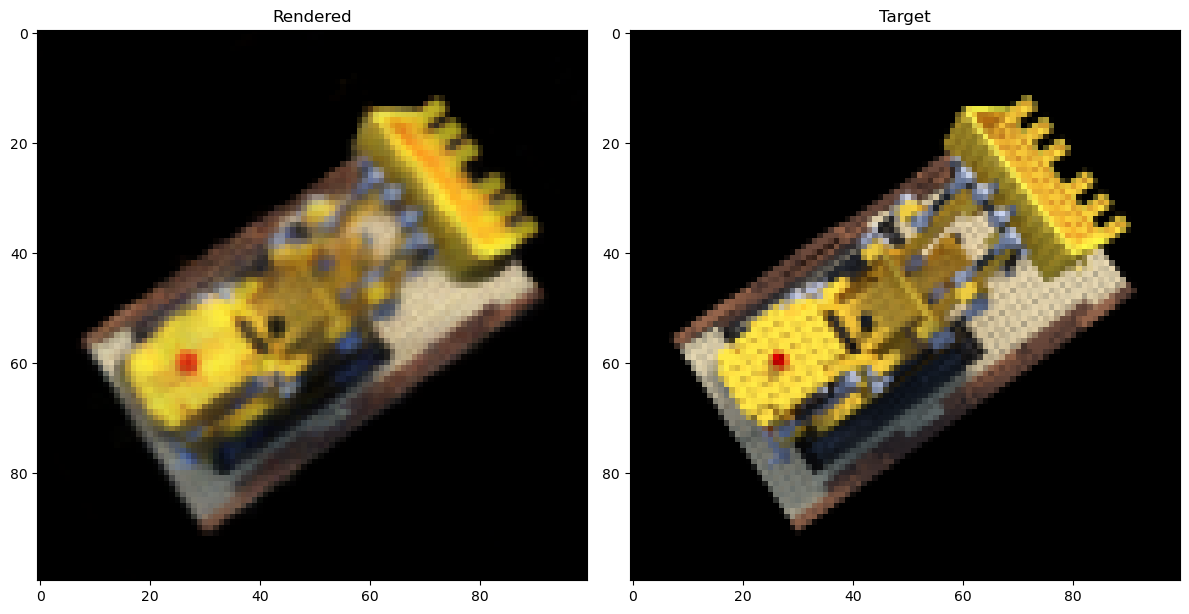

iteration 21000, loss is: 0.004039577208459377


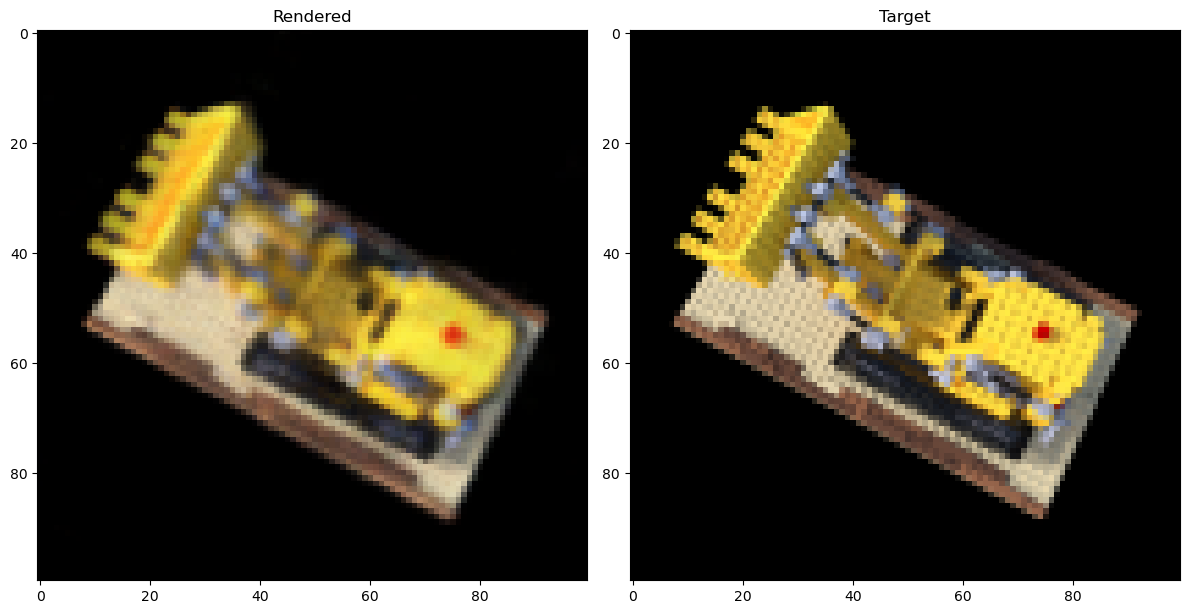

iteration 22000, loss is: 0.004894781857728958


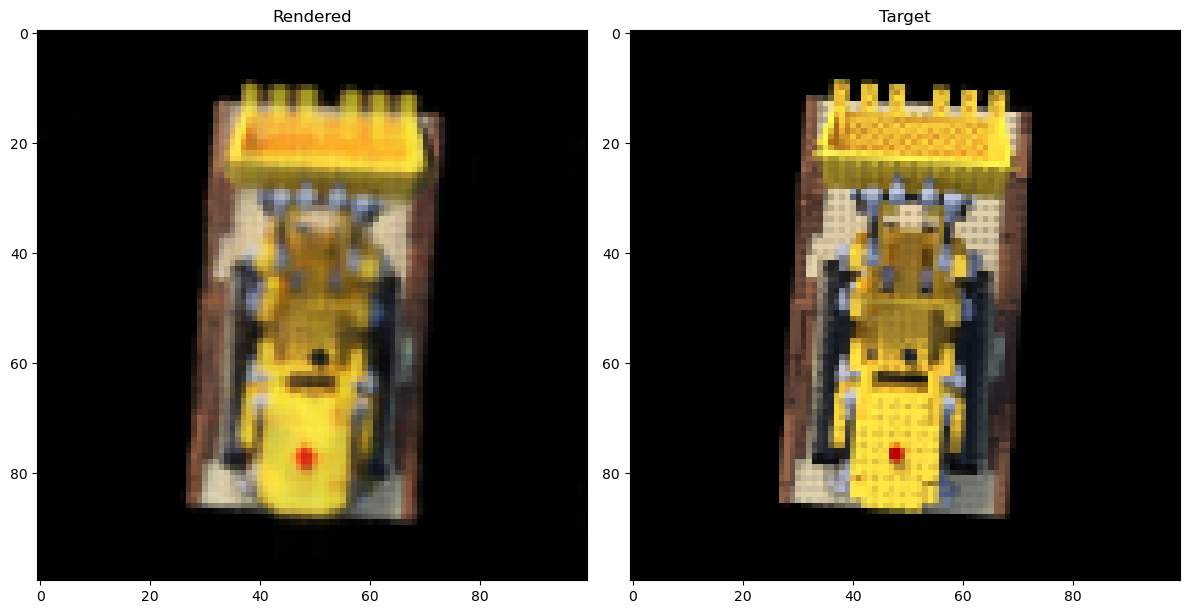

iteration 23000, loss is: 0.002417216543108225


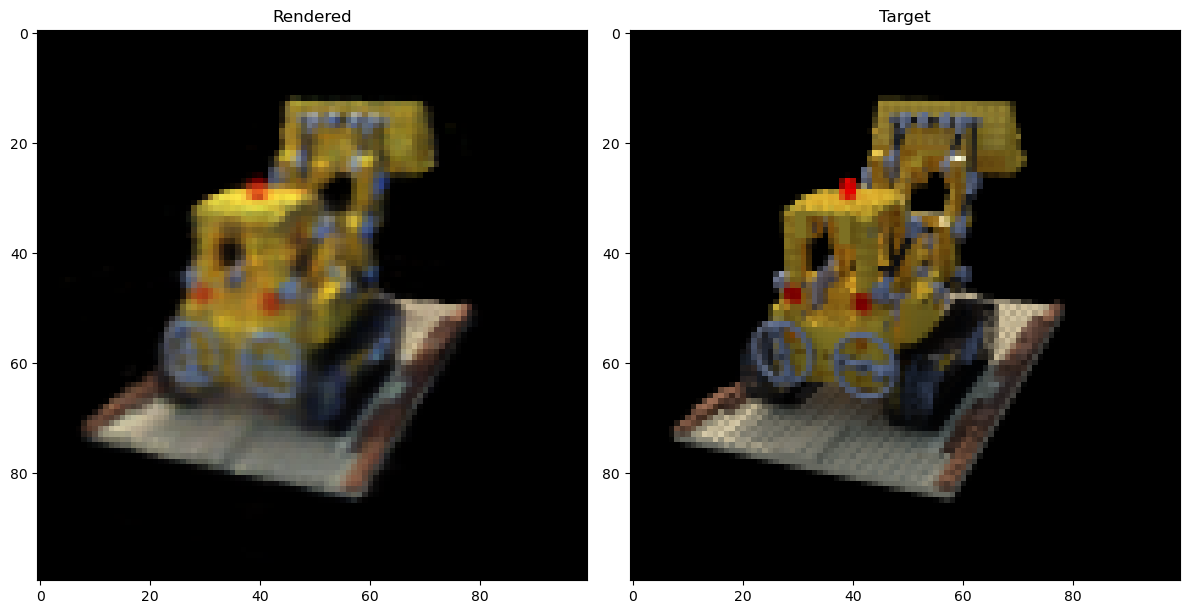

iteration 24000, loss is: 0.003960436210036278


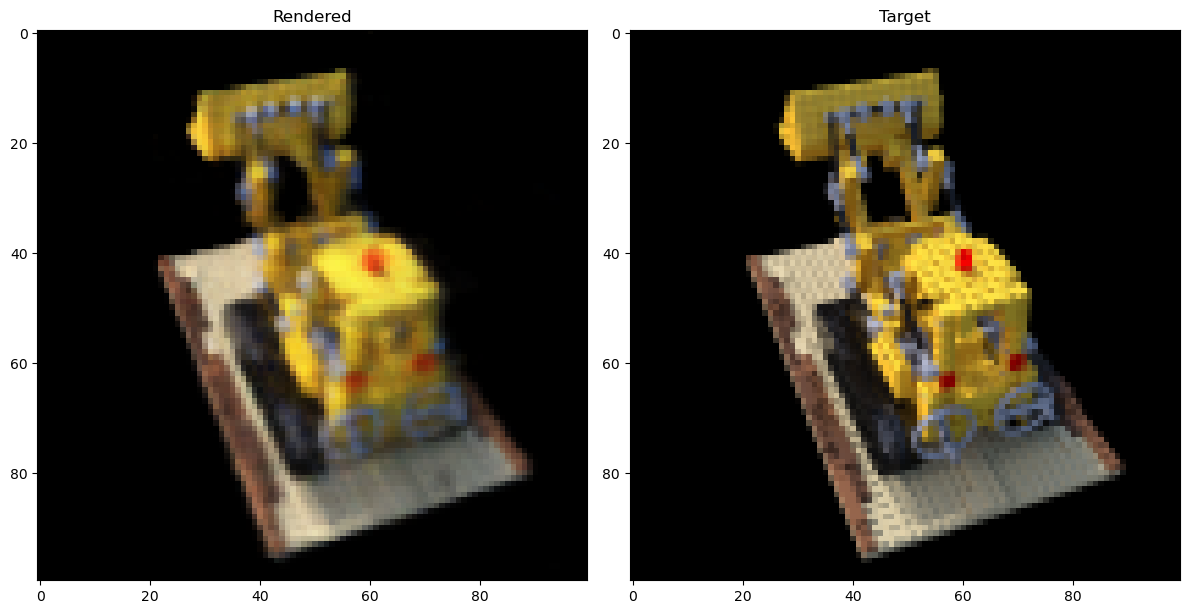

iteration 25000, loss is: 0.0036595191340893507


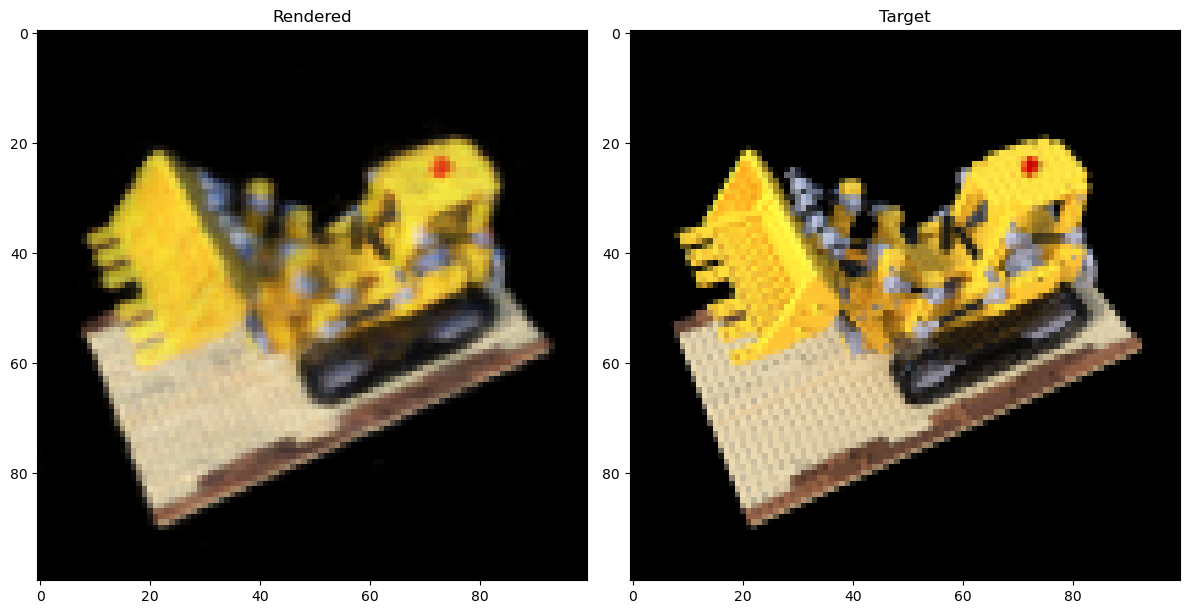

iteration 26000, loss is: 0.004072119481861591


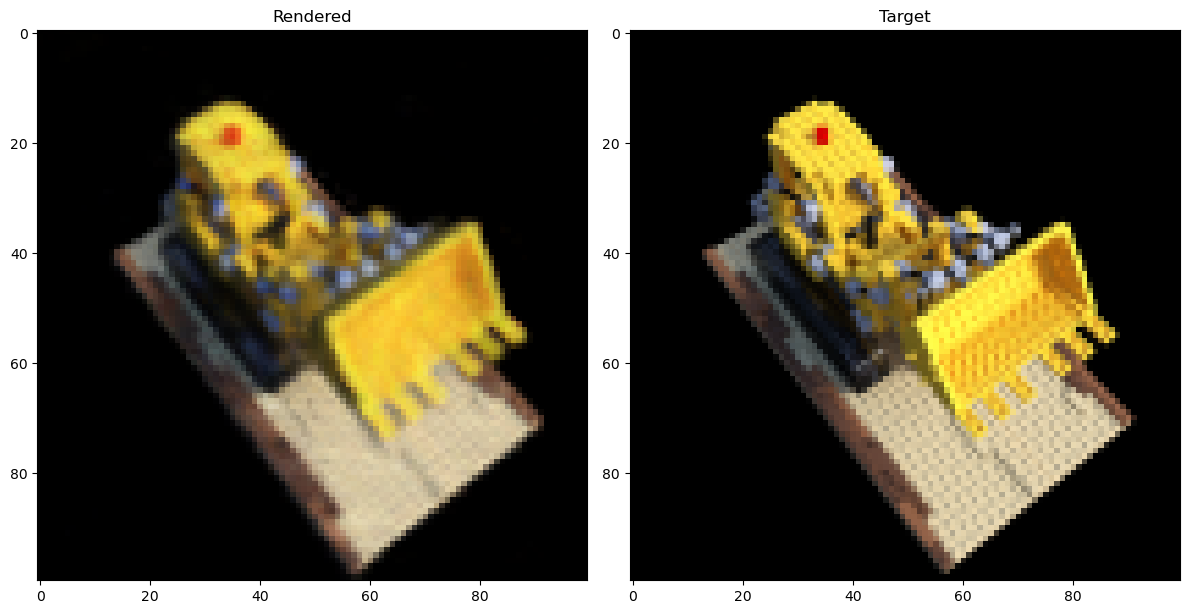

iteration 27000, loss is: 0.003604210214689374


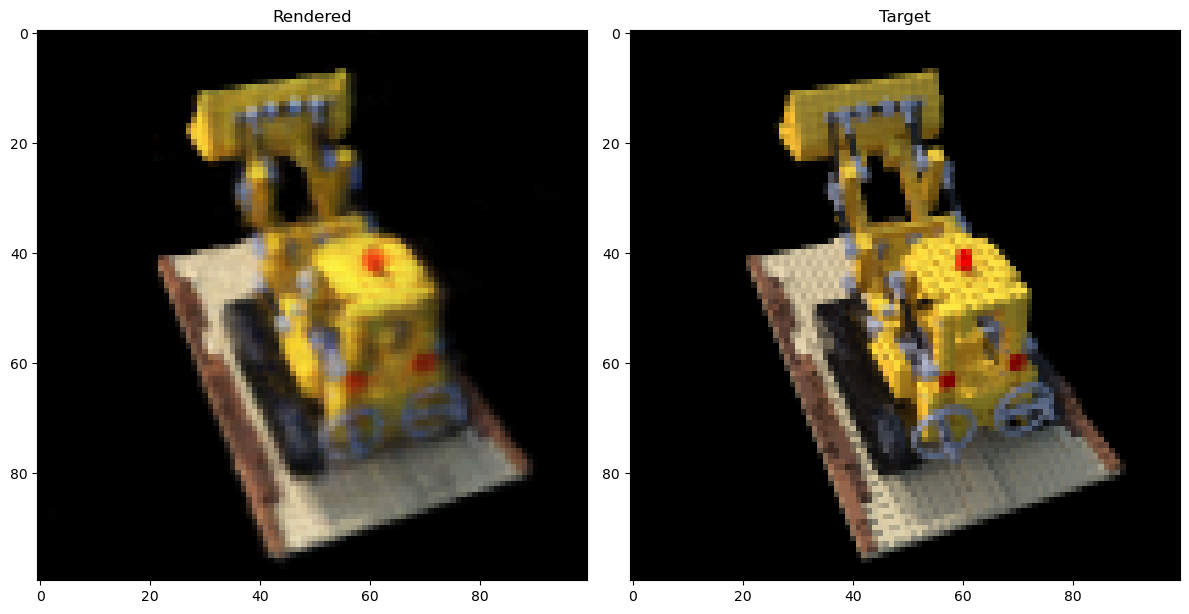

iteration 28000, loss is: 0.0024479024577885866


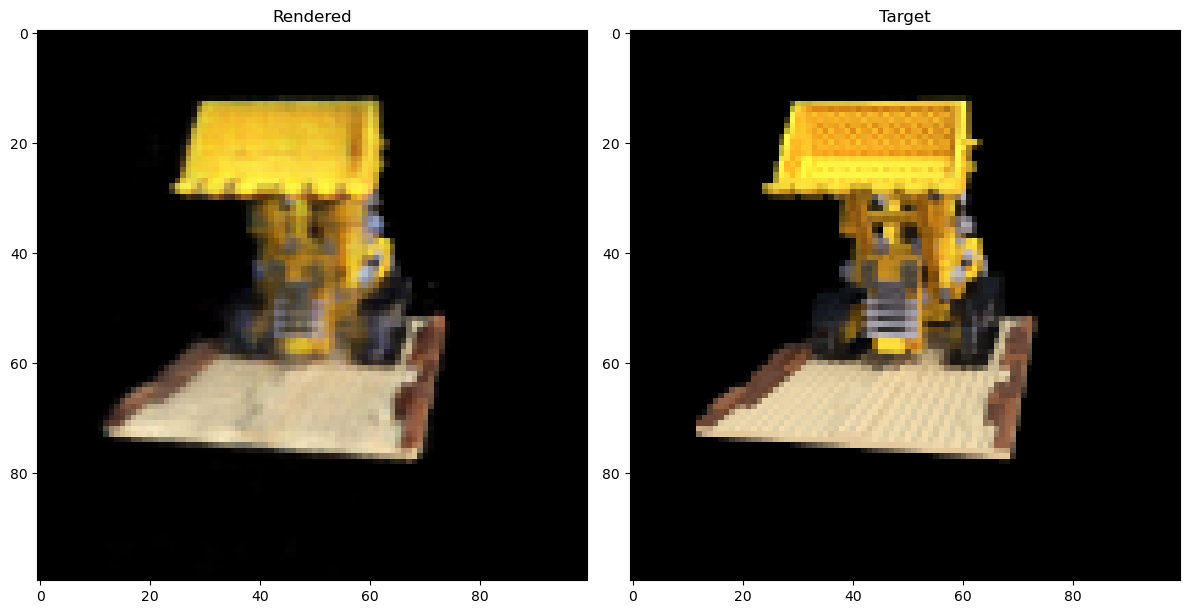

KeyboardInterrupt: 

In [23]:
def train(images, poses, H, W, focal, val_image, val_pose):
    loss_fn = nn.MSELoss(reduction='mean')
    optim = torch.optim.Adam(model.parameters(), lr=5e-4)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.99)
    
    max_iters = 100_000
    samples = 128
    plot_iters = 1000

    psnrs = []
    iternums = []
    loss_history = []

    for i in range(max_iters):
        image_index = np.random.randint(0, len(images))
        # image_index = 0

        target_img = images[image_index]
        pose = poses[image_index]
        
        rays_o, rays_d = generate_rays(H, W, focal, pose)
        optim.zero_grad()
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=samples, device=device, rand=True)
        rgb = rgb.reshape(H, W, 3)
        loss = loss_fn(rgb, target_img)
        loss_history.append(loss.item())

        loss.backward()
        optim.step()

        if i % plot_iters == 0:
            print(f"iteration {i}, loss is: {loss}")
            fig, axes = plt.subplots(1, 2, figsize=(12, 6))
            axes[0].imshow(rgb.cpu().detach())
            axes[0].set_title('Rendered')
            axes[1].imshow(target_img.cpu().detach())
            axes[1].set_title('Target')
            plt.tight_layout()
            plt.show()

height, width = images.shape[1:3]
# print(images.shape)
val_image = images[101]
val_pose = poses[101]

train_images = images[:100]
train_poses = poses[:100]
# print(focal)
train(torch.from_numpy(train_images).to(device), torch.from_numpy(train_poses).to(device), height, width, focal, val_image, val_pose)

In [40]:
torch.save(model.state_dict(), '28000_try2.pth')

In [27]:
# This video code is based off the original tiny nerf: https://colab.research.google.com/github/bmild/nerf/blob/master/tiny_nerf.ipynb
trans_t = lambda t: torch.tensor([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, t],
    [0, 0, 0, 1]
], dtype=torch.float32)

rot_phi = lambda phi: torch.tensor([
    [1, 0, 0, 0],
    [0, torch.cos(phi), -torch.sin(phi), 0],
    [0, torch.sin(phi), torch.cos(phi), 0],
    [0, 0, 0, 1]
], dtype=torch.float32)

rot_theta = lambda th: torch.tensor([
    [torch.cos(th), 0, -torch.sin(th), 0],
    [0, 1, 0, 0],
    [torch.sin(th), 0, torch.cos(th), 0],
    [0, 0, 0, 1]
], dtype=torch.float32)

def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = torch.matmul(rot_phi(torch.Tensor([phi / 180. * np.pi])), c2w)
    c2w = torch.matmul(rot_theta(torch.Tensor([theta / 180. * np.pi])), c2w)
    c2w = torch.tensor([[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]], dtype=torch.float32) @ c2w
    return c2w

def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = generate_rays(height, width, focal, c2w[:3, :4]) 
    c2w, rays_o, rays_d = map(lambda t: t.to(device), (c2w, rays_o, rays_d))
    with torch.no_grad():
      rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=64, device=device)  
    rgb = rgb.reshape(height, width, 3).cpu().detach()
    img = torch.clamp(rgb, 0, 1).numpy() 

    plt.figure(2, figsize=(20, 6))
    plt.imshow(img)
    plt.show()

sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0]: sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

In [37]:
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    rays_o, rays_d = generate_rays(height, width, focal, c2w[:3,:4])
    c2w, rays_o, rays_d = map(lambda t: t.to(device), (c2w, rays_o, rays_d))
    with torch.no_grad():
      rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=64, device = device)
    rgb = rgb.reshape(height, width, 3)
    frames.append((255*np.clip(rgb.cpu().detach().numpy(),0,1)).astype(np.uint8))


100%|██████████| 120/120 [00:02<00:00, 56.89it/s]


In [39]:
import imageio
import numpy as np

# Assuming `frames` is already a list of uint8 NumPy arrays (H, W, 3)
imageio.mimwrite("video.mp4", frames, fps=30, quality=7)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (100, 100) to (112, 112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x37b8ca00] Warning: data is not aligned! This can lead to a speed loss
